In [2]:
import os
import pandas as pd
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import onnx
import onnxruntime as ort
import dianna
from dianna.utils.downloader import download

import lilio
import urllib
import xarray as xr
from s2spy import preprocess
from s2spy import RGDR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from skl2onnx import to_onnx
import numpy as np
import onnxruntime as ort
from pathlib import Path

np.random.seed(0)


In [3]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [4]:
# URL of the dataset from zenodo
sst_url = "https://zenodo.org/record/8186914/files/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_url = "https://zenodo.org/record/8186914/files/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"
sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

urllib.request.urlretrieve(sst_url, sst_field)
urllib.request.urlretrieve(t2m_url, t2m_field)

('t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc',
 <http.client.HTTPMessage at 0x28e64e850>)

In [5]:
# load data
precursor_field = xr.open_dataset(sst_field)
target_field = xr.open_dataset(t2m_field)

In [6]:
# Convert Kelvin to Celsius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

precursor_field["sst"]

<xarray.DataArray 'sst' (time: 23011, latitude: 5, longitude: 13)> Size: 6MB
array([[[ 4.5313416,  4.7592773,  4.791046 , ...,  9.813629 ,
         10.054443 ,        nan],
        [ 9.401642 ,  9.50238  ,  9.232147 , ..., 13.3013   ,
         12.059631 ,        nan],
        [14.909058 , 14.611206 , 13.936432 , ..., 16.158813 ,
         15.250061 ,        nan],
        [17.729095 , 17.209045 , 17.254883 , ..., 18.419525 ,
         17.452576 , 16.059723 ],
        [21.414642 , 21.081177 , 21.19519  , ..., 20.536987 ,
         20.157837 , 19.038544 ]],

       [[ 4.5148315,  4.734741 ,  4.779999 , ...,  9.735046 ,
         10.004791 ,        nan],
        [ 9.477478 ,  9.524109 ,  9.195129 , ..., 13.205841 ,
         12.021576 ,        nan],
        [14.941101 , 14.554749 , 13.899506 , ..., 16.097992 ,
         15.239532 ,        nan],
        [17.751404 , 17.179077 , 17.208588 , ..., 18.379333 ,
         17.414917 , 16.034332 ],
        [21.363983 , 21.05246  , 21.138123 , ..., 20.513367 ,
...
          8.609131 ,        nan],
        [11.347321 , 11.90744  , 10.969849 , ..., 11.58194  ,
         10.469666 ,        nan],
        [17.545685 , 17.472015 , 16.298096 , ..., 15.150604 ,
         13.657745 ,        nan],
        [20.180786 , 20.450775 , 20.495758 , ..., 17.703949 ,
         16.177673 , 15.147278 ],
        [23.279663 , 23.220917 , 23.420929 , ..., 19.381927 ,
         18.745575 , 18.442108 ]],

       [[ 6.2053223,  6.8349304,  7.1759033, ...,  7.8821106,
          8.597443 ,        nan],
        [11.3125305, 11.913757 , 11.627136 , ..., 11.394623 ,
         10.45224  ,        nan],
        [17.558838 , 17.495178 , 16.934326 , ..., 15.096527 ,
         13.639862 ,        nan],
        [19.986694 , 20.286316 , 20.467682 , ..., 17.722656 ,
         16.222748 , 14.986694 ],
        [23.27536  , 23.16034  , 23.313873 , ..., 19.275269 ,
         18.723877 , 18.360687 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31
  * longitude  (longitude) float64 104B 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * latitude   (latitude) float64 40B 47.5 42.5 37.5 32.5 27.5

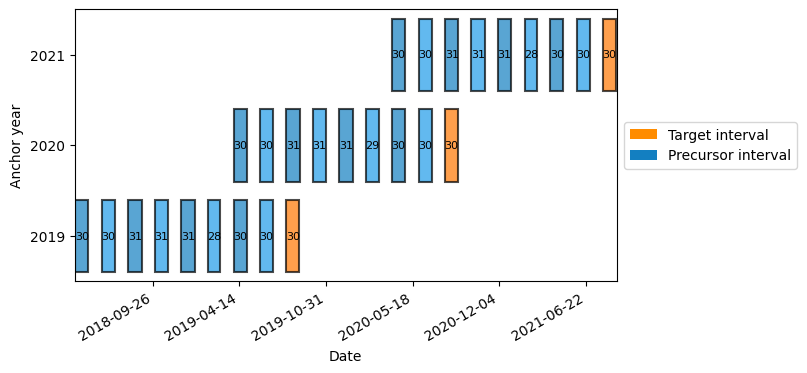

In [7]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [8]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
start_year = years[0]

In [9]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:150: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


In [10]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

In [11]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [12]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

In [13]:
# load onnx model and check the prediction with it
model_path = Path('/Users/clairedonnelly/AI4S2S/cookbook/workflow','model.onnx')


In [14]:
idx = 6 # explained instance
data_instance = data_test[idx][np.newaxis, ...]
# precheck ONNX predictions
pred_onnx = run_model(data_instance)
pred_class = classes[np.argmax(pred_onnx)]
print("The predicted class is:", pred_class)
print("The actual class is:", classes[np.argmax(target_test.iloc[idx])])

NameError: name 'data_test' is not defined

In [ ]:
import onnxruntime as ort

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [ ]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='rise',
                                     mode ='classification', training_data = X_train.to_numpy(),
                                     feature_names=input_features.columns, class_names=species)

In [ ]:
run_model(data_instance[None,...])

In [ ]:
from dianna.visualization import plot_tabular

_ = plot_tabular(explanation[np.argmax(predictions)], X_test.columns, num_features=10)